# ランダムフォレスト
### FGの有無を予測する（閾値1600m）

#### データの前処理

In [1]:
import numpy as np
import pandas as pd
np.random.seed(443)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
## 学習用データ
DATA = pd.read_csv("train_data.csv")

# 使うデータを限定
use_valiable = ["DateTime","VIS","VIS_CAT","FG","PRCP_P24HR",\
                "RH_SFC","TMP_SFC","TD_SFC","PRES_SFC","LCDC_SFC","MCDC_SFC","HCDC_SFC",\
                "WSPD_SFC","WDIR_SFC","APCP_SFC","TimeRange","MONTH",\
#                 "D_PRES_SFC","D_TMP_SFC","D_TD_SFC",\
                "LL_VWS1","LL_VWS2","LL_STBL1","LL_STBL2","WARMER_RA",\
                "RH_1000","VVEL_1000","WSPD_1000","RH_975","VVEL_975","WSPD_975",\
                "RH_950","VVEL_950","WSPD_950","RH_850","RH_700","RH_500","RH_300"]
DATA = DATA[use_valiable]

# カテゴリー変数はダミー化
cat_val = ['WDIR_SFC', 'TimeRange', 'MONTH']
DATA = pd.get_dummies(data=DATA, columns=cat_val)

# 雨が降った後の夜間に霧が出やすいことを表現できるかもしれない
DATA["Time_12-14_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_12-14"]
DATA["Time_15-17_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_15-17"]
DATA["Time_18-20_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_18-20"]
DATA["Time_21-23_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_21-23"]

# 不均衡データ対応
# VIS 5000m以上を減らし、VIS 5000m未満を増やす
def Sampling_Flag(data):
    flag = np.full( data.shape[0], 0 )
    flag[ data > 0 ] = 1
    return flag

DATA["FLAG"] = Sampling_Flag( DATA.VIS_CAT )

target = 'FLAG'
exclude = ['FLAG','DateTime']
features = [val for val in DATA.columns if val not in exclude]

y = np.array( DATA[target] )
X = np.array( DATA[features] )

# count = int( y[y==0].shape[0]/2 )
# rus = RandomUnderSampler(ratio={0:count}, random_state=443)
# X_rus, y_rus = rus.fit_sample(X,y)

# count = y_rus[y_rus==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X_rus,y_rus)

# count = y[y==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X,y)

# DATA = pd.DataFrame( X_sm, columns=features )
DATA = pd.DataFrame( X, columns=features )
DATA.FG = DATA.FG.astype(np.int64)
DATA.VIS_CAT = DATA.VIS_CAT.astype(np.int64)

In [3]:
## 予測テスト用データ
TEST = pd.read_csv("test_data.csv")
TEST = TEST[use_valiable].drop("DateTime", axis=1)
TEST = pd.get_dummies(data=TEST, columns=cat_val)

TEST["Time_12-14_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_12-14"]
TEST["Time_15-17_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_15-17"]
TEST["Time_18-20_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_18-20"]
TEST["Time_21-23_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_21-23"]

### ランダムフォレスト

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
import re

% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

In [5]:
target = 'FG'
exclude = ['VIS','VIS_CAT','FG','PRCP_P24HR']
features = [val for val in DATA.columns if val not in exclude]

# 特徴量を割り算で作成
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(features)-1):
    for j in range(i+1, len(features)):
        first_col_name = features[i]
        second_col_name = features[j]
        r = spearmanr(DATA[first_col_name], DATA[second_col_name]).correlation        
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            DATA[new_colname] = DATA[first_col_name] / (DATA[second_col_name] + 0.001)
            new_added_col.append(new_colname)
features = features + new_added_col

# 増えた特徴量をテストデータでも作成
for feature in features:
    if re.search('_div_', feature):
        feature1, feature2 = feature.split("_div_")
        TEST[feature] = TEST[feature1] / (TEST[feature2] + 0.001)

X = np.array( DATA[features] )
Y = np.array( DATA[target] )
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

X_test = np.array( TEST[features] )
Y_test = np.array( TEST[target] )

In [10]:
# スレットスコアが最も高くなる閾値を求める
def Best_TS_Cutoff(y_test, y_proba):
    accuracy = []
    for i in range(1,100):
        var = i / 100
        ypred_flag = (y_proba[:,1] > var).astype(np.int)
        m = confusion_matrix(y_true=y_test, y_pred=ypred_flag)
        ts = m[1,1] / ( m[0,1] + m[1,0] + m[1,1] )
        accuracy.append( ts )
    return (np.argsort(accuracy)[-1] + 1) / 100

# Equitable Threat Scoreを使う
def Best_ETS_Cutoff(y_test, y_proba):
    Pc = len(y_test[ y_test == 1 ]) / len(y_test) # 気候学的出現率
    accuracy = []
    for i in range(1,100):
        var = i / 100
        ypred_flag = (y_proba[:,1] > var).astype(np.int)
        m = confusion_matrix(y_true=y_test, y_pred=ypred_flag)
        Sf = Pc * ( m[1,1] + m[0,1] ) # ランダム的中率
        ets = ( m[1,1] - Sf ) / ( m[0,1] + m[1,0] + m[1,1] - Sf )
        accuracy.append( ets )
    return (np.argsort(accuracy)[-1] + 1) / 100

# 評価計算を出力
def Evaluation(y_test, y_proba):
    #cutoff = Best_TS_Cutoff( y_test, y_proba )
    cutoff = Best_ETS_Cutoff( y_test, y_proba )
    y_fcst = (y_proba[:,1] > cutoff).astype(np.int)
    y_fcst = np.argmax(y_proba, axis=1)

    print( "AUC : {}" . format( roc_auc_score(y_test, y_proba[:,1]) ) )
    print( "" )
    print( "cutoff : {}" . format(cutoff) )
    print( classification_report(y_true=y_test, y_pred=y_fcst) )
    matrix = confusion_matrix(y_true=y_test, y_pred=y_fcst)
    print( "Confusion Matrix" )
    print( matrix )
    print( "" )
    print( "Threat Score : {}" . format( matrix[1,1]/(matrix[0,1]+matrix[1,0]+matrix[1,1]) ) )
    Pc = len(y_test[ y_test == 1 ]) / len(y_test)
    Sf = Pc * ( matrix[1,1] + matrix[0,1] )
    print( "ETS : {}" . format( (matrix[1,1]-Sf)/(matrix[0,1]+matrix[1,0]+matrix[1,1]-Sf) ) )
    print( "BI : {}" . format( matrix[:,1].sum() / matrix[1,:].sum() ) )
    return cutoff

In [11]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=4, min_samples_leaf=2,\
                            class_weight='balanced', random_state=443)
rf.fit(X_train, Y_train)
y_proba = rf.predict_proba(X_dev)
cutoff = Evaluation( Y_dev, y_proba )

AUC : 0.9479957091489143

cutoff : 0.6
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      7739
          1       0.23      0.59      0.33       116

avg / total       0.98      0.97      0.97      7855

Confusion Matrix
[[7516  223]
 [  48   68]]

Threat Score : 0.20058997050147492
ETS : 0.19032600265719418
BI : 2.5086206896551726


### 予測実験

In [12]:
def Final_Accuracy(y_test, y_proba, cutoff):
    y_fcst = (y_proba[:,1] > cutoff).astype(np.int)

    print( "AUC : {}" . format( roc_auc_score(y_test, y_proba[:,1]) ) )
    print( "" )
    print( "cutoff : {}" . format(cutoff) )
    print( classification_report(y_true=y_test, y_pred=y_fcst) )
    matrix = confusion_matrix(y_true=y_test, y_pred=y_fcst)
    print( "Confusion Matrix" )
    print( matrix )
    print( "" )
    print( "Threat Score : {}" . format( matrix[1,1]/(matrix[0,1]+matrix[1,0]+matrix[1,1]) ) )
    Pc = len(y_test[ y_test == 1 ]) / len(y_test)
    Sf = Pc * ( matrix[1,1] + matrix[0,1] )
    print( "ETS : {}" . format( (matrix[1,1]-Sf)/(matrix[0,1]+matrix[1,0]+matrix[1,1]-Sf) ) )
    print( "BI : {}" . format( matrix[:,1].sum() / matrix[1,:].sum() ) )

In [13]:
# 予測テスト
y_proba = rf.predict_proba(X_test)
Final_Accuracy( Y_test, y_proba, cutoff )

AUC : 0.9030545565131284

cutoff : 0.6
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      8038
          1       0.15      0.20      0.17        99

avg / total       0.98      0.98      0.98      8137

Confusion Matrix
[[7923  115]
 [  79   20]]

Threat Score : 0.09345794392523364
ETS : 0.08644621699780031
BI : 1.3636363636363635


### 重要度を見る

In [14]:
rcParams['figure.figsize'] = 10,10
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

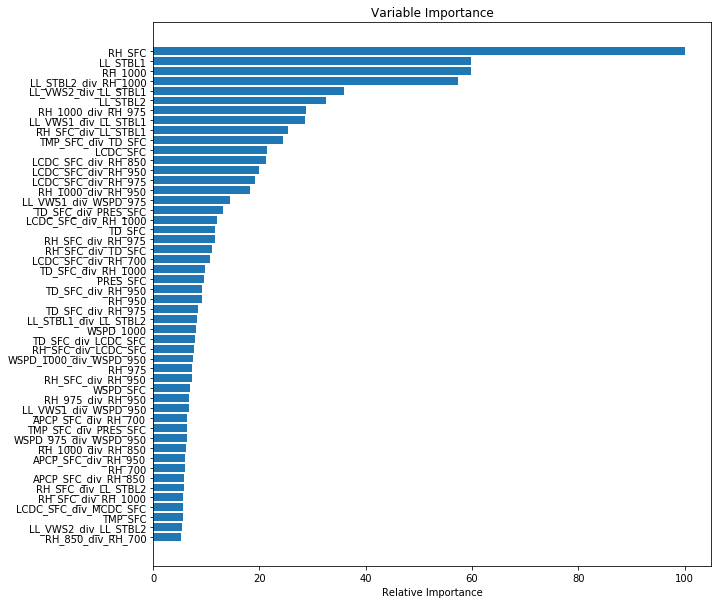

In [15]:
varImpPlot(rf, features, topN=50, verbose=False)

In [16]:
# 一定の重要度がなければ除外する場合に実行
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(features)
selected_features = feature_cols_ar[feature_importance > 1]

# 改めて学習用データをセット
X = np.array( DATA[selected_features] )
Y = np.array( DATA[target] )
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

X_test = np.array( TEST[selected_features] )
Y_test = np.array( TEST[target] )

# 再学習と評価
rf.fit(X_train, Y_train)
y_proba = rf.predict_proba(X_dev)
cutoff = Evaluation( Y_dev, y_proba )

AUC : 0.9482630518956829

cutoff : 0.58
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      7739
          1       0.24      0.55      0.33       116

avg / total       0.98      0.97      0.97      7855

Confusion Matrix
[[7533  206]
 [  52   64]]

Threat Score : 0.19875776397515527
ETS : 0.1887117242262779
BI : 2.3275862068965516


In [17]:
# 予測テスト
y_proba = rf.predict_proba(X_test)
Final_Accuracy( Y_test, y_proba, cutoff )

AUC : 0.8992827001037998

cutoff : 0.58
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      8038
          1       0.13      0.18      0.15        99

avg / total       0.98      0.97      0.98      8137

Confusion Matrix
[[7915  123]
 [  81   18]]

Threat Score : 0.08108108108108109
ETS : 0.07392486840673824
BI : 1.4242424242424243


### PCAで次元圧縮した特徴量を試す

In [106]:
## 学習用データ
DATA = pd.read_csv("train_data.csv")

# 使うデータを限定
use_valiable = ["DateTime","VIS","VIS_CAT","FG","PRCP_P24HR",\
                "RH_SFC","TMP_SFC","TD_SFC","PRES_SFC","LCDC_SFC","MCDC_SFC","HCDC_SFC",\
                "WSPD_SFC","WDIR_SFC","TimeRange","MONTH","APCP_SFC",\
#                 "D_PRES_SFC","D_TMP_SFC","D_TD_SFC",\
                "LL_VWS1","LL_VWS2","LL_STBL1","LL_STBL2","WARMER_RA",\
                "RH_1000","VVEL_1000","WSPD_1000","RH_975","VVEL_975","WSPD_975",\
                "RH_950","VVEL_950","WSPD_950","RH_850","RH_700","RH_500","RH_300"]
DATA = DATA[use_valiable]

# カテゴリー変数はダミー化
cat_val = ['WDIR_SFC', 'TimeRange', 'MONTH']
DATA = pd.get_dummies(data=DATA, columns=cat_val)

# 雨が降った後の夜間に霧が出やすいことを表現できるかもしれない
DATA["Time_12-14_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_12-14"]
DATA["Time_15-17_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_15-17"]
DATA["Time_18-20_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_18-20"]
DATA["Time_21-23_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_21-23"]

# 不均衡データ対応
# VIS 5000m以上を減らし、VIS 5000m未満を増やす
def Sampling_Flag(data):
    flag = np.full( data.shape[0], 0 )
    flag[ data > 0 ] = 1
    return flag

DATA["FLAG"] = Sampling_Flag( DATA.VIS_CAT )

target = 'FLAG'
exclude = ['FLAG','DateTime']
features = [val for val in DATA.columns if val not in exclude]

y = np.array( DATA[target] )
X = np.array( DATA[features] )

# count = int( y[y==0].shape[0]/2 )
# rus = RandomUnderSampler(ratio={0:count}, random_state=443)
# X_rus, y_rus = rus.fit_sample(X,y)

# count = y_rus[y_rus==0].shape[0]
# sm = SMOTE(ratio={1:count}, random_state=443)
# X_sm, y_sm = sm.fit_sample(X_rus,y_rus)

count = y[y==0].shape[0]
sm = SMOTE(ratio={1:count}, random_state=443)
X_sm, y_sm = sm.fit_sample(X,y)

DATA = pd.DataFrame( X_sm, columns=features )
# DATA = pd.DataFrame( X, columns=features )
DATA.FG = DATA.FG.astype(np.int64)
DATA.VIS_CAT = DATA.VIS_CAT.astype(np.int64)

In [107]:
## 予測テスト用データ
TEST = pd.read_csv("test_data.csv")
TEST = TEST[use_valiable].drop("DateTime", axis=1)
TEST = pd.get_dummies(data=TEST, columns=cat_val)

TEST["Time_12-14_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_12-14"]
TEST["Time_15-17_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_15-17"]
TEST["Time_18-20_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_18-20"]
TEST["Time_21-23_RAp24hr"] = TEST["PRCP_P24HR"] * TEST["TimeRange_21-23"]

In [108]:
target = 'FG'
exclude = ['VIS','VIS_CAT','FG','PRCP_P24HR']
features = [val for val in DATA.columns if val not in exclude]

## Scaling
# 湿度と雲量は100で割る
rh_val = ["RH_SFC", "RH_1000", "RH_975", "RH_950", "RH_850", "RH_700", "RH_500", "RH_300",\
          "LCDC_SFC", "MCDC_SFC", "HCDC_SFC"]
DATA[rh_val] /= 100.0
TEST[rh_val] /= 100.0

# それ以外の連続量は正規化（0〜1）
cont_val = ["TMP_SFC","TD_SFC","PRES_SFC","WSPD_SFC","APCP_SFC",\
#             "D_PRES_SFC","D_TMP_SFC","D_TD_SFC",\
            "LL_VWS1","LL_VWS2","LL_STBL1","LL_STBL2","WARMER_RA","VVEL_1000","WSPD_1000",\
            "VVEL_975","WSPD_975","VVEL_950","WSPD_950"]
scaler = MinMaxScaler(feature_range=(0, 1))
DATA[cont_val] = scaler.fit_transform( DATA[cont_val] )
TEST[cont_val] = scaler.transform( TEST[cont_val] )

## 主成分分析
pca = PCA(n_components=10)
DATA_P = pca.fit_transform( DATA[features] )
TEST_P = pca.transform( TEST[features] )
DATA_INV = pca.inverse_transform( DATA_P )
TEST_INV = pca.inverse_transform( TEST_P )

X = DATA_INV
Y = np.array( DATA[target] )
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

X_test = TEST_INV
Y_test = np.array( TEST[target] )

In [78]:
## グリッドサーチでハイパーパラメータのチューニング
rf = RandomForestClassifier(class_weight='balanced', random_state=443)
params = {'n_estimators' :[100, 150, 200], 'max_depth':[5, 10, None]}
gcv = GridSearchCV(rf, param_grid=params, n_jobs=-1, cv=3, scoring='roc_auc', verbose=1)
gcv.fit(X_train, Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   58.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=443,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200], 'max_depth': [5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [79]:
print( gcv.best_params_ )
print( gcv.best_score_ )

{'max_depth': 10, 'n_estimators': 150}
0.9297718568033404


In [125]:
# 学習と検証
# rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=4, min_samples_leaf=2,\
#                             class_weight='balanced', random_state=443)
# rf = RandomForestClassifier(**gcv.best_params_, class_weight='balanced', random_state=443)
# rf = RandomForestClassifier(**gcv.best_params_, random_state=443)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=4, min_samples_leaf=2,\
                            class_weight={1: 2}, random_state=443)
rf.fit(X_train, Y_train)
y_proba = rf.predict_proba(X_dev)
cutoff = Evaluation( Y_dev, y_proba )

AUC : 0.9628196375213887

cutoff : 0.39
             precision    recall  f1-score   support

          0       0.96      0.99      0.98     12980
          1       0.87      0.47      0.61       905

avg / total       0.96      0.96      0.96     13885

Confusion Matrix
[[12914    66]
 [  481   424]]

Threat Score : 0.43666323377960864
ETS : 0.41750425745759706
BI : 0.5414364640883977


In [126]:
# 予測テスト
y_proba = rf.predict_proba(X_test)
Final_Accuracy( Y_test, y_proba, cutoff )

AUC : 0.8658166637763552

cutoff : 0.39
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      8038
          1       0.27      0.14      0.19        99

avg / total       0.98      0.98      0.98      8137

Confusion Matrix
[[8000   38]
 [  85   14]]

Threat Score : 0.10218978102189781
ETS : 0.09802446060411618
BI : 0.5252525252525253
